In [1]:
import glob

import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
print(tf.__version__)

from sklearn.model_selection import train_test_split

from src.classes import Boundary
from src.performance_evaluation import (
    center_of_mass,
    compute_position_error,
    compute_volume_error,
    compute_voxel_error,
)
from src.util import plot_voxel, plot_voxel_c, voxel_ball
import os

import pandas as pd
import seaborn as sns

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

boundary = Boundary()

2025-01-15 11:04:47.948482: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736939087.965847 1238770 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736939087.970251 1238770 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-15 11:04:47.991710: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.18.0


In [2]:
from dataclasses import dataclass

@dataclass
class BallAnomaly:  #  FOR VAE TRAINING ONLY
    x: float
    y: float
    z: float
    d: float
    γ: float

In [3]:
ball = BallAnomaly(x=10.5, y=10, z=10, d=8, γ=1)

In [4]:
ball_vxl = voxel_ball(ball, boundary)

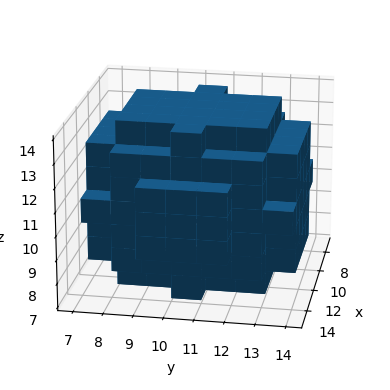

In [5]:
plot_voxel(ball_vxl)

In [6]:
X_all_anomalys = list()
diameter_labels = list()
pos_ball = list()
vol_ball = list()

max_d = 8

for γ in [1]:  # set object geometries to 1 and empty space to 0
    for d in [8]:  # diameter
        for x in np.linspace(boundary.x_0 + max_d, boundary.x_length - max_d, 20):
            for y in np.linspace(boundary.y_0 + max_d, boundary.y_length - max_d, 20):
                for z in np.linspace(
                    boundary.z_0 + max_d, boundary.z_length - max_d, 20
                ):
                    ball = BallAnomaly(x, y, z, d, γ)
                    vxl_ball = voxel_ball(ball, boundary)

                    X_all_anomalys.append(vxl_ball)
                    diameter_labels.append(d)
                    pos_ball.append([ball.y, ball.x, ball.z])  #  y,x,z in 3d Plot!!!
                    vol_ball.append(np.where(vxl_ball == 1)[0].shape[0])

X_all_anomalys = np.array(X_all_anomalys) / 2
diameter_labels = np.array(diameter_labels)
pos_ball = np.array(pos_ball)
vol_ball = np.array(vol_ball)

In [7]:
print(X_all_anomalys.shape, diameter_labels.shape)

(8000, 32, 32, 32) (8000,)


In [8]:
(
    X_train,
    X_test,
    r_train,
    r_test,
    pos_train,
    pos_test,
    vol_train,
    vol_test,
) = train_test_split(
    X_all_anomalys,
    diameter_labels,
    pos_ball,
    vol_ball,
    train_size=0.9,
    shuffle=True,
    random_state=42,
)

In [9]:
print(
    X_train.shape,
    X_test.shape,
    r_train.shape,
    r_test.shape,
    pos_train.shape,
    pos_test.shape,
    vol_train.shape,
    vol_test.shape,
)

(7200, 32, 32, 32) (800, 32, 32, 32) (7200,) (800,) (7200, 3) (800, 3) (7200,) (800,)


3666
Pos:	 [10.52631579 20.63157895 19.78947368]
Vol:	 269


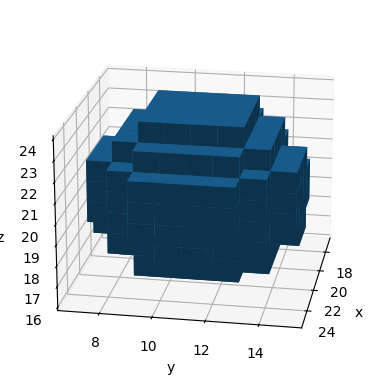

2687
Pos:	 [22.31578947 13.89473684 16.42105263]
Vol:	 272


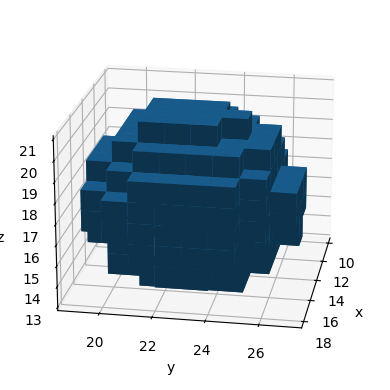

1619
Pos:	 [ 8.         21.47368421 19.78947368]
Vol:	 260


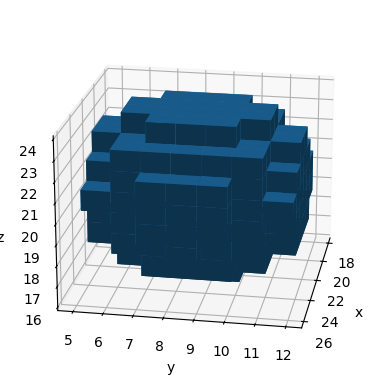

4377
Pos:	 [13.89473684 23.15789474 20.63157895]
Vol:	 266


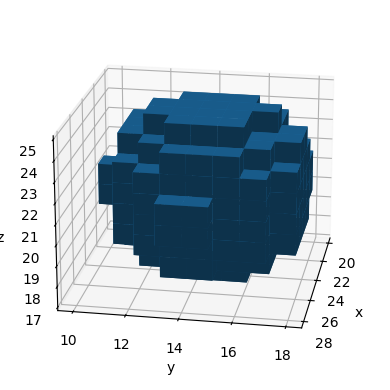

6107
Pos:	 [21.47368421 19.78947368 18.10526316]
Vol:	 265


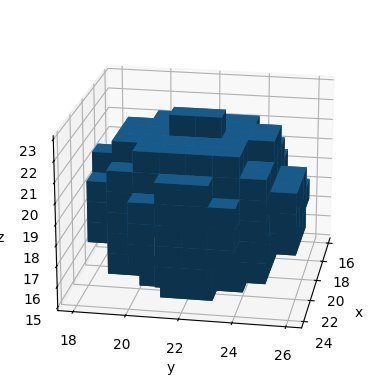

In [10]:
for rdn in np.random.randint(low=0, high=X_train.shape[0], size=5):
    print(rdn)
    print("Pos:\t", pos_train[rdn])
    print("Vol:\t", vol_train[rdn])
    plot_voxel_c(X_train[rdn, ...] * 2)

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.backend import random_normal
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv3D,
    Conv3DTranspose,
    Dense,
    Flatten,
    Input,
    Layer,
    Reshape,
)
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import Mean
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

filters = [1, 2, 4, 8]
kernels = [(3,3,3) for _ in range(4)]
strides = [(1, 1, 1), (2, 2, 2), (2, 2, 2), (2, 2, 2)]
paddings = ["same", "same", "same", "same"]

latent_dim = 8


class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class VAE(Model):
    def __init__(self, encoder, decoder, beta=1.0, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = Mean(name="total_loss")
        self.reconstruction_loss_tracker = Mean(name="reconstruction_loss")
        self.kl_loss_tracker = Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.total_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            kl_loss = 1 + z_log_var - tf.pow(z_mean, 2) - tf.exp(z_log_var)
            kl_loss = -0.5 * tf.reduce_sum(kl_loss, axis=-1)
            reconstruction_loss = binary_crossentropy(
                data, reconstruction, axis=(1, 2, 3)
            )  #
            reconstruction_loss *= np.prod((32, 32, 32, 1))
            # β-VAE
            # print("beta value:",self.beta)
            total_loss = reconstruction_loss + self.beta * kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "total_loss": self.total_loss_tracker.result(),
        }

    def get_config(self):
        config = super(VAE, self).get_config()
        config.update(
            {
                "encoder": tf.keras.utils.serialize_keras_object(self.encoder),
                "decoder": tf.keras.utils.serialize_keras_object(self.decoder),
                "beta": self.beta,
            }
        )
        return config


def encoder_model(
    input_shape=(32, 32, 32, 1),
    filters=filters,
    kernels=kernels,
    strides=strides,
    paddings=paddings,
    latent_dim=latent_dim,
):
    encoder_inputs = Input(shape=input_shape)
    x = BatchNormalization()(encoder_inputs)

    for fltr, krnl, strd, pddng in zip(filters, kernels, strides, paddings):
        x = Conv3D(
            filters=fltr,
            kernel_size=krnl,
            strides=strd,
            padding=pddng,
            activation="elu",
        )(x)
        x = BatchNormalization()(x)

    x = Flatten()(x)

    z_mean = Dense(latent_dim, name="z_mean", activation="sigmoid")(x)
    z_log_var = Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()((z_mean, z_log_var))

    return encoder_inputs, z_mean, z_log_var, z


def decoder_model(
    input_shape=(32, 32, 32, 1),
    filters=filters[::-1],
    kernels=kernels[::-1],
    strides=strides[::-1],
    paddings=paddings[::-1],
    latent_dim=latent_dim,
):
    latent_inputs = Input(shape=(latent_dim,))
    x = Dense(512, activation="relu")(latent_inputs)
    x = Reshape((4, 4, 4, 8))(x)

    for fltr, krnl, strd, pddng in zip(filters, kernels, strides, paddings):
        x = Conv3DTranspose(
            filters=fltr,
            kernel_size=krnl,
            strides=strd,
            padding=pddng,
            activation="elu",
        )(x)
        x = BatchNormalization()(x)

    decoded = x

    return latent_inputs, decoded


def vae_model(
    input_shape=(32, 32, 32, 1),
    filters=filters,
    kernels=kernels,
    strides=strides,
    paddings=paddings,
    latent_dim=latent_dim,
    beta=1.0,
):
    encoder_inputs, z_mean, z_log_var, z = encoder_model(
        input_shape=(32, 32, 32, 1),
        filters=filters,
        kernels=kernels,
        strides=strides,
        paddings=paddings,
        latent_dim=latent_dim,
    )
    encoder = Model(encoder_inputs, (z_mean, z_log_var, z), name="VAE_encoder")

    decoder_inputs, decoder_outputs = decoder_model(
        input_shape=(32, 32, 32, 1),
        filters=filters[::-1],
        kernels=kernels[::-1],
        strides=strides[::-1],
        paddings=paddings[::-1],
        latent_dim=latent_dim,
    )
    decoder = Model(decoder_inputs, decoder_outputs, name="VAE_decoder")

    return VAE(encoder, decoder, beta=beta)


# engineering decoder and encoder parts:

encoder_inputs, z_mean, z_log_var, z = encoder_model(
    input_shape=(32, 32, 32, 1),
    filters=filters,
    kernels=kernels,
    strides=strides,
    paddings=paddings,
    latent_dim=latent_dim,
)
encoder = Model(encoder_inputs, (z_mean, z_log_var, z), name="VAE_encoder")

decoder_inputs, decoder_outputs = decoder_model(
    input_shape=(32, 32, 32, 1),
    filters=filters[::-1],
    kernels=kernels[::-1],
    strides=strides[::-1],
    paddings=paddings[::-1],
    latent_dim=latent_dim,
)
decoder = Model(decoder_inputs, decoder_outputs, name="VAE_decoder")

encoder.summary()
decoder.summary()

W0000 00:00:1736939108.232428 1238770 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "VAE_encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32,    │          0 │ -                 │
│ (InputLayer)        │ 32, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │          4 │ input_layer[0][0] │
│ (BatchNormalizatio… │ 32, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 32, 32,    │         28 │ batch_normalizat… │
│                     │ 32, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │          4 │ conv3d[0][0]      │
│ (BatchNormalizatio… │ 32, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 16, 16,    │         56 │ batch_normalizat… │
│                     │ 16, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │          8 │ conv3d_1[0][0]    │
│ (BatchNormalizatio… │ 16, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 8, 8, 8,   │        220 │ batch_normalizat… │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 8,   │         16 │ conv3d_2[0][0]    │
│ (BatchNormalizatio… │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 4, 4, 4,   │        872 │ batch_normalizat… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 4,   │         32 │ conv3d_3[0][0]    │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 8)         │      4,104 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 8)         │      4,104 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 8)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,448 (36.91 KB)

 Trainable params: 9,416 (36.78 KB)

 Non-trainable params: 32 (128.00 B)

Model: "VAE_decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 4, 8)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_transpose                │ (None, 8, 8, 8, 8)     │         1,736 │
│ (Conv3DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 8, 8)     │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_transpose_1              │ (None, 16, 16, 16, 4)  │           868 │
│ (Conv3DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 16, 4)  │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_transpose_2              │ (None, 32, 32, 32, 2)  │           218 │
│ (Conv3DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 32, 2)  │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_transpose_3              │ (None, 32, 32, 32, 1)  │            55 │
│ (Conv3DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 32, 1)  │             4 │
│ (BatchNormalization)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,545 (29.47 KB)

 Trainable params: 7,515 (29.36 KB)

 Non-trainable params: 30 (120.00 B)

In [12]:
epochs = 100
batch_size = 32
beta = 0.98

#cb = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=0, start_from_epoch=47)

vae = vae_model(input_shape=(32, 32, 32, 1), filters=[1, 4, 8, 16], beta=beta)
vae.compile(optimizer=Adam())  # learning_rate = learning_rate

history = vae.fit(
    np.expand_dims(X_train, 4),
    epochs=epochs,
    batch_size=batch_size,
    #callbacks=[cb],
)

Epoch 1/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 29s 111ms/step - kl_loss: 8.3715 - loss: 922.5740 - reconstruction_loss: 914.3701 - total_loss: 922.5740
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 25s 109ms/step - kl_loss: 7.3848 - loss: 720.6901 - reconstruction_loss: 713.4530 - total_loss: 720.6901
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 24s 109ms/step - kl_loss: 19.7955 - loss: 487.4032 - reconstruction_loss: 468.0036 - total_loss: 487.4032
Epoch 4/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 24s 108ms/step - kl_loss: 25.7841 - loss: 349.5433 - reconstruction_loss: 324.2748 - total_loss: 349.5433
Epoch 5/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 25s 109ms/step - kl_loss: 27.4320 - loss: 300.5486 - reconstruction_loss: 273.6652 - total_loss: 300.5486
Epoch 6/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 25s 109ms/step - kl_loss: 27.6062 - loss: 399.9807 - reconstruction_loss: 372.9267 - total_loss: 399.9807
Epoch 7/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 25s 109ms/step - kl_loss: 24.5609 - loss: 354.9270 - reconstruction_loss: 330.8

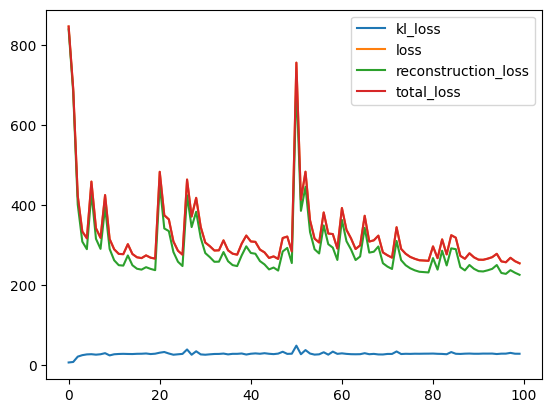

In [13]:
for keys in history.history.keys():
    plt.plot(history.history[keys], label=keys)
    plt.legend()
plt.show()

In [17]:
vae = vae_model()  # Erstelle die gleiche Modellinstanz
vae.build(input_shape=(32, 32, 32, 1))  # Baue das Modell mit der passenden Eingabeform
vae_idx = len(glob.glob("weights/3Dvae*.h5")) + 1
vae.save_weights(f"weights/3Dvae_{vae_idx}.weights.h5")

Original...


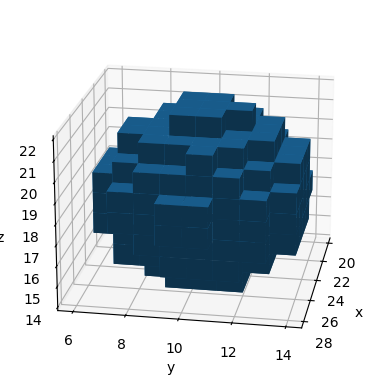

Prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


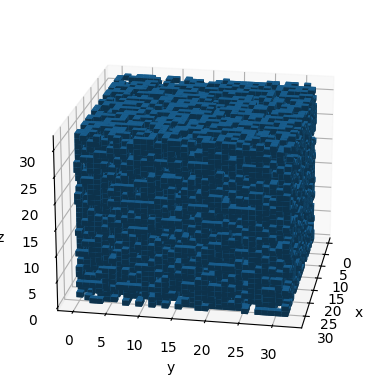

Original...


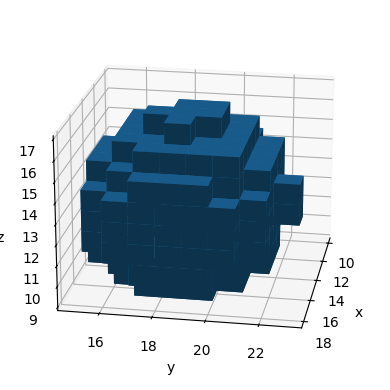

Prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


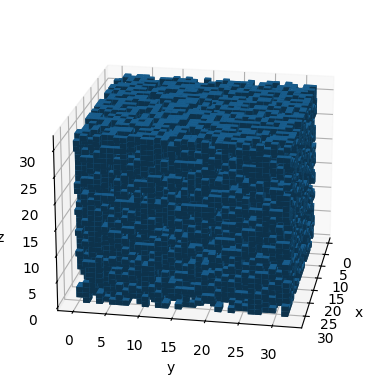

Original...


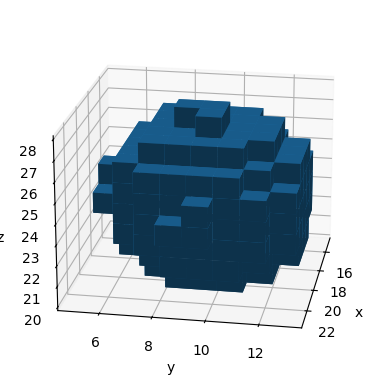

Prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


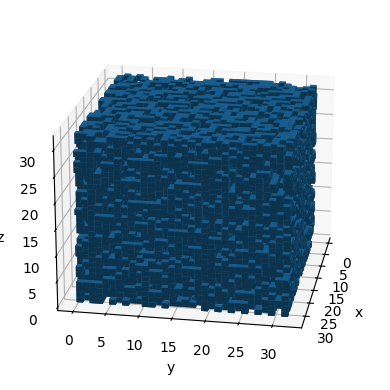

Original...


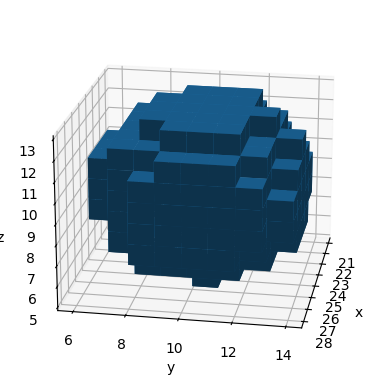

Prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


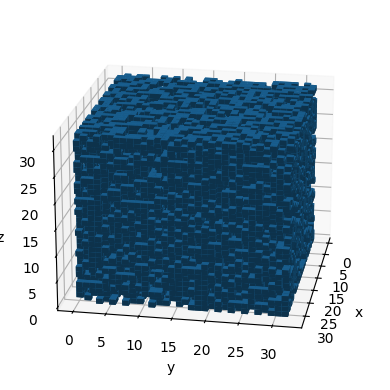

Original...


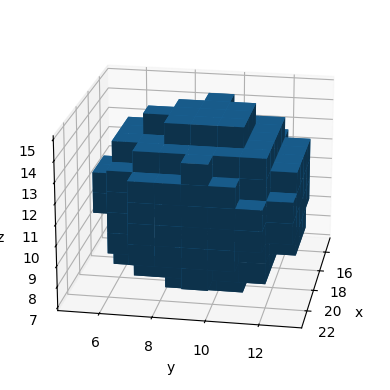

Prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


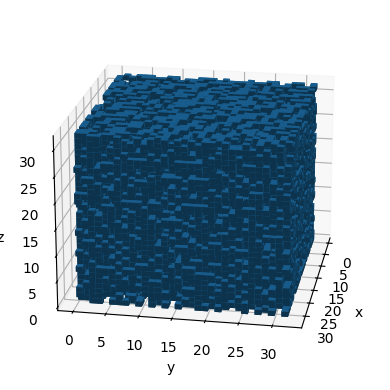

In [18]:
plt.style.use("default")
for rdn in np.random.randint(low=0, high=X_test.shape[0], size=5):
    print("Original...")
    plot_voxel_c(X_test[rdn, ...])

    print("Prediction...")
    _, _, z = vae.encoder.predict(np.expand_dims(X_test[rdn, ...], 0))
    sgl_pred = vae.decoder.predict(z)
    sgl_pred = np.squeeze(sgl_pred, axis=4)
    sgl_pred = np.squeeze(sgl_pred, axis=0)
    sgl_pred = np.clip(sgl_pred, a_min=0, a_max=1)
    plot_voxel_c(sgl_pred)

In [19]:
acc_measure = dict(Model=list(), Error_val=list(), Error=list(), test_idx=list())
# Apply test data to previously trained VAE
_, _, z = vae.encoder.predict(X_test)
X_pred = vae.decoder.predict(z)
X_pred = np.squeeze(X_pred, axis=4)
X_pred = np.clip(X_pred, a_min=0, a_max=1)
# X_pred = np.round(X_pred, 1) + 0.15  #  round offset
# X_pred = np.round(X_pred)


data_append = []

for idx, v_err in enumerate(compute_volume_error(X_pred, X_test)):
    v_percent = (v_err / 32**3) * 100
    data_append.append(
        dict(Model=vae_idx, Error_val=v_percent, Error="Volume", test_idx=idx)
    )

for idx, p_err in enumerate(compute_position_error(pos_test, X_pred)):
    p_percent = (p_err / np.linalg.norm(np.array([32, 32, 32]))) * 100
    data_append.append(
        dict(Model=vae_idx, Error_val=p_percent, Error="Position", test_idx=idx)
    )

# Iterativ das Dictionary erweitern
for item in data_append:
    for key, value in item.items():
        acc_measure[key].append(value)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


In [20]:
acc_measure_df = pd.DataFrame(acc_measure).dropna()
#acc_measure_df.to_csv(f"models/vaes/vae_acc_measure_{vae_idx}.csv", index=False)
acc_measure_df

,Model,Error_val,Error,test_idx
0,2,49.554443,Volume,0
1,2,49.713135,Volume,1
2,2,49.703979,Volume,2
3,2,49.539185,Volume,3
4,2,49.722290,Volume,4
...,...,...,...,...
1595,2,12.056853,Position,795
1596,2,11.040427,Position,796
1597,2,15.220525,Position,797
1598,2,10.987770,Position,798


Text(0, 0.5, 'Error (%)')

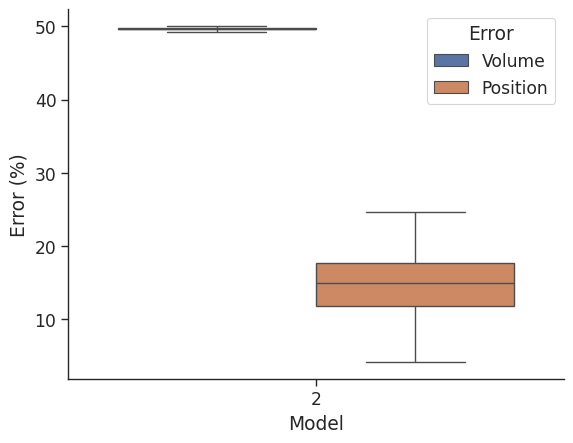

In [21]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
sns.set_context(context="paper", font_scale=1.4)

sns.boxplot(
    x="Model", y="Error_val", data=acc_measure_df, hue="Error", showfliers=False
)  #  violinplot: , split=True
plt.ylabel("Error (%)")
# plt.xlabel("Model Iteration")